In [1]:

import pygame
import random
import os
import time
import numpy as np
import math
import torch
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy.interpolate import griddata
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)



pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


cuda:0


In [2]:
global temp_list
temp_list = []
Agent_number_n=4;
Alpha = 0.64

# Hyper Parameters
echo = 2001
BATCH_SIZE = 64
LR_G = 0.0005           # learning rate for generator
LR_D = 0.0005           # learning rate for discriminator
N_IDEAS = Agent_number_n             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = Agent_number_n     # it could be total point G can draw in the canvas

Is_GAN = True # if use Gan

def Generate_distribution(Agent_number_n):
    return sorted(np.random.rand(Agent_number_n), reverse=True)
    #return sorted(np.random.normal(normalloc,normalscale,Agent_number_n))

In [3]:
def h_3_star(a, b, t):
    return a - min(a, t) + b - min(b, t) + max(min(a, t)+min(b, t), 2*t/3) + 1/2 * max(min(a, t)+min(b, t), t) - 1/2 * max(max(min(a, t), min(b, t)), 2*t/3) - t/6


def f_function(a, b, z):
    if(z >= 1):
        return (a+b)/2 + z/3
    else:
        return z/3 + h_3_star(a, b, 1-z)/2

def h_function_label(input_list):
    #input_list = sorted(input_list)
    g_list = []
    for j1 in range(len(input_list) ):
        for j2 in range(len(input_list)):
            if(j1 != j2):
                a = input_list[j1]
                b = input_list[j2]
                z = sum(input_list)- a-b

                g_list.append( f_function(a, b, z) * (Agent_number_n-1))
    h = sum(g_list) * 3 /  (Agent_number_n) /  (Agent_number_n-1) /  (Agent_number_n - 2)
    return h

def appen(_x_list,y):
    global temp_list
    temp_list.append(_x_list)
    
def appen_train(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    h_list = []
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
        
        h = h_function_label(temp)
        h_list.append(float(h))
    temp_list = np.array(temp_list)
    x_list = np.array(x_list)
    return temp_list,S,x_list,h_list
    

def appen_test(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data.append(temp_list)
    testing_label.append(S)
    temp_list = np.array(temp_list)
    return temp_list,S
    

def read_testing_data():
    for i in range(10000):
        appen_test(Generate_distribution(Agent_number_n));
                            

testing_data=[]
testing_label=[]
S=1.0
read_testing_data();

testing_data=np.array(testing_data)
testing_label=np.array(testing_label)
print(testing_data)
print(testing_label)

[[[0.6296199  0.16428312 0.02135004]
  [0.72693163 0.16428312 0.02135004]
  [0.72693163 0.6296199  0.02135004]
  [0.72693163 0.6296199  0.16428312]]

 [[0.72624192 0.43927588 0.24831071]
  [0.95824557 0.43927588 0.24831071]
  [0.95824557 0.72624192 0.24831071]
  [0.95824557 0.72624192 0.43927588]]

 [[0.54655145 0.33835037 0.23127281]
  [0.66952469 0.33835037 0.23127281]
  [0.66952469 0.54655145 0.23127281]
  [0.66952469 0.54655145 0.33835037]]

 ...

 [[0.3617713  0.16659563 0.06292157]
  [0.95262855 0.16659563 0.06292157]
  [0.95262855 0.3617713  0.06292157]
  [0.95262855 0.3617713  0.16659563]]

 [[0.31382345 0.10691546 0.00950515]
  [0.71071537 0.10691546 0.00950515]
  [0.71071537 0.31382345 0.00950515]
  [0.71071537 0.31382345 0.10691546]]

 [[0.67274149 0.36020593 0.27449534]
  [0.92429048 0.36020593 0.27449534]
  [0.92429048 0.67274149 0.27449534]
  [0.92429048 0.67274149 0.36020593]]]
[1.54218469 2.37207409 1.78569934 ... 1.54391705 1.14095943 2.23173324]


In [4]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()
        
        self.input_dim = (Agent_number_n-1)
        self.hidden_dim = 128
        self.output_dim = 1
        self.hidden_layer_count = 6 
        
        current_dim = self.input_dim
        self.layers = torch.nn.ModuleList()
        for i in range(self.hidden_layer_count):
            self.layers.append(torch.nn.Linear(current_dim, self.hidden_dim))
            current_dim = self.hidden_dim
        self.layers.append(torch.nn.Linear(current_dim, self.output_dim))

    def calculate(self, value_list):
        h = value_list
        LeakyReLU = torch.nn.LeakyReLU()
        for layer in self.layers:
            h = torch.relu(layer(h))
        return h

    def forward(self, input_list,input_label,list_x):
        global iteration,echo,target_order
        loss1 = 0
        loss2 = 0
        loss3 = 0
        input_list = torch.from_numpy(
            np.array(input_list)).to(dev).type(torch.float32)
        h_list = []

        for i in range(Agent_number_n):
            h = self.calculate(input_list[i])
            h_list.append(h)
#             loss3 += torch.square(h_function_2(input_list)-h2[1])
            
        input_label = torch.from_numpy(
            np.array(input_label)).to(dev).type(torch.float32)
        sum_h = torch.sum(torch.cat(h_list)).to(dev)


        loss1 = torch.where((Agent_number_n-1)*input_label>sum_h,
                        torch.square(((Agent_number_n-1)*input_label-sum_h)),
                        torch.zeros(1).to(dev)
                      )

        loss2 = torch.where((Agent_number_n-Alpha)*input_label<sum_h,
                        torch.square((sum_h-(Agent_number_n-Alpha)*input_label))/100,
                        torch.zeros(1).to(dev)
                      )


        return loss1,loss2
    
    def supervised_loss(self, input_list,label):
        global iteration,echo,target_order
        input_list = torch.from_numpy(
            np.array(input_list)).to(dev).type(torch.float32)
        loss = 0 
        for i in range(Agent_number_n):
            h = self.calculate(input_list[i])
            loss += torch.square(h - label[i])
        return loss

In [5]:
def redistribution_value_function(input_tensor):
    S = torch.max(torch.sum(input_tensor), torch.ones(1).to(dev))
    temp_list = []


    for i in range(Agent_number_n):
        temp = []
        
        for j in range(Agent_number_n):
            if(i != j):
                temp .append(input_tensor[j])
                
        temp = torch.stack(temp)
        temp_list.append(temp)
    return torch.stack(temp_list), S

GeneratorNet = nn.Sequential(                      # Generator
    # random ideas (could from normal distribution)
    nn.Linear(N_IDEAS, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    # making a painting from these random ideas
    nn.Linear(64, ART_COMPONENTS),
    nn.Sigmoid(),
)

In [6]:
random.seed(2000)
torch.manual_seed(256)
DiscriminatorNet  = Net()
DiscriminatorNet.apply(weight_init)
GeneratorNet.apply(weight_init)
DiscriminatorNet = torch.load("save/Deep_learning_D_4_gan_1")
if(Is_GAN):
    GeneratorNet = torch.load("save/Deep_learning_G_4_1")
DiscriminatorNet.to(dev)
GeneratorNet.to(dev)

opt_D = torch.optim.Adam(DiscriminatorNet.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(GeneratorNet.parameters(), lr=LR_G)


scheduler_D = torch.optim.lr_scheduler.StepLR(opt_D, step_size=100, gamma=0.98)
scheduler_G = torch.optim.lr_scheduler.StepLR(opt_G, step_size=100, gamma=0.98)

index_train_list = []
index_test_list = []
train_losses = []
test_losses = []

In [7]:
#supervised
index_supervisedtrain_list = []
supervisedtrain_losses = []
for iteration in range(int(1000)):

    temp_number = 0
    total_batch_loss = 0 
    
    loss_sum = 0
    denominator = 0
    for index in range(0, BATCH_SIZE):
        training_data_i, training_S, training_data,label = appen_train(
            Generate_distribution(Agent_number_n))
        h_loss = DiscriminatorNet.supervised_loss(training_data_i, label)
        denominator += 1
        loss_sum += h_loss

    loss_sum = torch.sum(loss_sum)
    loss = (loss_sum) / denominator 
    total_batch_loss += float(loss_sum)

    opt_D.zero_grad()
    loss.backward()
    opt_D.step()

    if (iteration%100 == 0):
        print(iteration,loss,total_batch_loss)
        index_supervisedtrain_list.append(iteration)
        supervisedtrain_losses.append(total_batch_loss)
    scheduler_D.step()

0 tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) 0.10564491897821426
100 tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>) 0.008830081671476364
200 tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>) 0.007123796734958887
300 tensor(7.9291e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.005074651446193457
400 tensor(4.7456e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.003037160262465477
500 tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>) 0.00662061246111989
600 tensor(5.1057e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.003267669351771474
700 tensor(5.2649e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.003369544865563512
800 tensor(5.7262e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0036647918168455362
900 tensor(4.6944e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0030043977312743664
1000 tensor(3.7944e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0024283863604068756
1100 tensor(3.9200e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.00250878720544

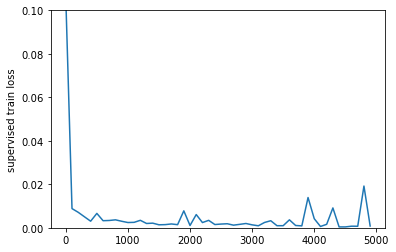

In [8]:
plt.ylim(0, 0.1)
plt.plot(index_supervisedtrain_list ,supervisedtrain_losses)
plt.ylabel('supervised train loss')

plt.show()

In [9]:
for iteration in range(int(echo)):

    temp_number = 0
    total_batch_loss = 0 
        
    loss2_list = []
    loss1_sum = 0
    loss2_sum = 0
    denominator = 0
    for index in range(0, BATCH_SIZE):
        training_data_i, training_label, training_data, label = appen_train(
            Generate_distribution(Agent_number_n))
        h_loss1, h_loss2 = DiscriminatorNet(training_data_i, training_label,
                                       training_data)
        denominator += 1
        loss1_sum += h_loss1
        loss2_sum += h_loss2

    loss_sum = torch.sum(loss1_sum + loss2_sum)
    loss = (loss_sum) / denominator 
    total_batch_loss +=float(loss_sum)

    opt_D.zero_grad()
    loss.backward()
    opt_D.step()

    temp_number = iteration
    index_train_list.append(iteration)
    train_losses.append(total_batch_loss)

    if (iteration%100 == 0):
        print(temp_number,loss,float(loss1_sum),float(loss2_sum))
    ## Gan 
        if(Is_GAN):## Gan Work traning GeneratorNet

            DiscriminatorNet.requires_grad = True
            GeneratorNet.requires_grad = True


            for step in range(10):
                # real painting from artist
                G_ideas = torch.randn(BATCH_SIZE, N_IDEAS,
                                      requires_grad=True).to(dev)  # random ideas\n
                # fake painting from G (random ideas)

                G_values = GeneratorNet(G_ideas)
                G_values , indices = torch.sort(G_values, descending=True)
            #     print(artist_paintings)
            #     print(G_paintings)

                result_list = []
                for index in range(BATCH_SIZE):
                    h_list = []
                    value_list_tensor, S_tensor = redistribution_value_function(
                        G_values[index])
                    for i in range(Agent_number_n):
                        h = DiscriminatorNet.calculate(
                            value_list_tensor[i].cuda().type(torch.float32))
                        h_list.append(h)
                    h_list = torch.stack(h_list)
                    result_list.append(torch.sum(h_list)/S_tensor.cuda())
                result_list = torch.stack(result_list)

                diff_loss = torch.max(result_list)-torch.min(result_list)
                G_loss = torch.max(- diff_loss)

                opt_G.zero_grad()
                G_loss.backward()
                opt_G.step()

            # real painting from artist
                G_ideas = torch.randn(BATCH_SIZE, N_IDEAS,
                                      requires_grad=True).to(dev)  # random ideas\n
                # fake painting from G (random ideas)

                G_values = GeneratorNet(G_ideas)
                G_values , indices = torch.sort(G_values, descending=True)
            #     print(artist_paintings)
            #     print(G_paintings)

                result_list = []
                for index in range(BATCH_SIZE):
                    h_list = []
                    value_list_tensor, S_tensor = redistribution_value_function(
                        G_values[index])
                    for i in range(Agent_number_n):
                        h = DiscriminatorNet.calculate(
                            value_list_tensor[i].cuda().type(torch.float32))
                        h_list.append(h)
                    h_list = torch.stack(h_list)
                    result_list.append(torch.sum(h_list)/S_tensor.cuda())
                result_list = torch.stack(result_list)

                diff_loss = torch.max(result_list)-torch.min(result_list)

                D_loss = torch.where((Agent_number_n-1)>torch.min(result_list),
                    torch.square(((Agent_number_n-1)-torch.min(result_list))),
                    torch.zeros(1).to(dev)
                  )   + torch.where((Agent_number_n-Alpha)<torch.max(result_list),
                                torch.square((torch.max(result_list)-(Agent_number_n-Alpha)))/10000,
                                torch.zeros(1).to(dev)
                              )


                opt_D.zero_grad()
                D_loss.backward()
                opt_D.step()
                
            print("Gan:",G_loss,D_loss)
            print()

            
        result_list = []
        for index in range(len(testing_data)):
            h_list = []
            for i in range(Agent_number_n):
                h = DiscriminatorNet.calculate(
                    torch.tensor(testing_data[index][i]).to(dev).type(
                        torch.float32))
                h_list.append(float(h))
            result_list.append(sum(h_list) / testing_label[index])
        print(max(result_list), min(result_list),
              max(result_list) - min(result_list),
              (sum(result_list) / len(result_list) - min(result_list))+ Agent_number_n-1 - min(min(result_list),Agent_number_n-1) )

        index_test_list.append(iteration)
        test_losses.append(
            (sum(result_list) / len(result_list) - min(result_list))+ Agent_number_n-1 - min(min(result_list),Agent_number_n-1) )
        print()
        index_test_list.append(iteration)
        test_losses.append(
            max(result_list)-min(result_list) )
        
  
        print()


    scheduler_D.step()
    scheduler_G.step()

0 tensor(0., device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
Gan: tensor(-0.8569, device='cuda:0', grad_fn=<MaxBackward1>) tensor([7.1646e-05], device='cuda:0', grad_fn=<AddBackward0>)

4.2273805141448975 3.233732329425131 0.9936481847197665 0.252444672870352


100 tensor(8.0380e-06, device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0005144319729879498
Gan: tensor(-0.9129, device='cuda:0', grad_fn=<MaxBackward1>) tensor([1.3246e-05], device='cuda:0', grad_fn=<AddBackward0>)

3.658748984336853 3.0387343955714394 0.6200145887654136 0.15173319983173528


200 tensor(0., device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
Gan: tensor(-0.8801, device='cuda:0', grad_fn=<MaxBackward1>) tensor([2.7164e-05], device='cuda:0', grad_fn=<AddBackward0>)

3.549465596675873 2.9897904992103577 0.5596750974655151 0.1637487632411858


300 tensor(0., device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
Gan: tensor(-0.7720, device='cuda:0', grad_fn=<MaxBackward1>) tensor([2.2082e-05], device='cuda:0', grad_fn=<AddBa

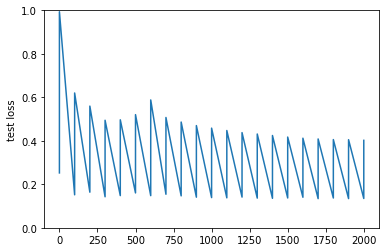

In [10]:
plt.ylim(0, 1.0)
plt.plot(index_test_list,test_losses)
plt.ylabel('test loss')

plt.show()

In [11]:
torch.save(DiscriminatorNet, "save/Deep_learning_D_4_gan_1")
if(Is_GAN):
    torch.save(GeneratorNet, "save/Deep_learning_G_4_1")

In [12]:
def h_3_star(a, b, t):
    return a - min(a, t) + b - min(b, t) + max(min(a, t)+min(b, t), 2*t/3) + 1/2 * max(min(a, t)+min(b, t), t) - 1/2 * max(max(min(a, t), min(b, t)), 2*t/3) - t/6


def f_function(a, b, z):
    if(z >= 1):
        return (a+b)/2 + z/3
    else:
        return z/3 + h_3_star(a, b, 1-z)/2

def h_function(input_list):
    #input_list = sorted(input_list)
    g_list = []
    for j1 in range(len(input_list) ):
        for j2 in range(len(input_list)):
            if(j1 != j2):
                a = input_list[j1]
                b = input_list[j2]
                z = sum(input_list)- a-b

                g_list.append( f_function(a, b, z) * (Agent_number_n-1))
    h = sum(g_list) * 3 /  (Agent_number_n) /  (Agent_number_n-1) /  (Agent_number_n - 2)
    return h
                
                
x_list = []
y_list = []
z_list = []
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        x_list.append(testing_data[index][i][0])
        y_list.append(testing_data[index][i][1])
        h = h_function(testing_data[index][i])
        z_list.append(float(h))
        h_list.append(float(h))
    result_list.append(sum(h_list)/testing_label[index]) 
    
    
print(max(result_list), min(result_list), max(result_list)-min(result_list),sum(result_list)/len(result_list))

3.3667379858927498 2.999999999999999 0.36673798589275064 3.1223365332309982


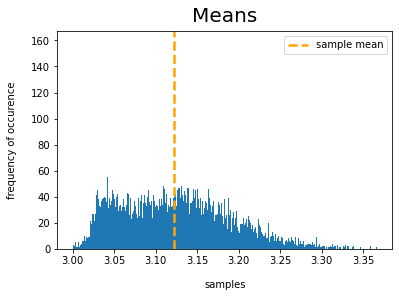

In [13]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

# result_list.sort()

# plt.axvline(x=result_list[int(len(result_list)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
# plt.axvline(x=result_list[int(len(result_list)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [14]:
def read_testing_data():
    for i in range(100000):
        appen_test(Generate_distribution(Agent_number_n));
        
testing_data=[]
testing_label=[]
S=1.0
read_testing_data();

testing_data=np.array(testing_data)
testing_label=np.array(testing_label)
print(testing_data)
print(testing_label)

[[[0.61276434 0.60552607 0.44851615]
  [0.79130828 0.60552607 0.44851615]
  [0.79130828 0.61276434 0.44851615]
  [0.79130828 0.61276434 0.60552607]]

 [[0.54731539 0.37578378 0.2699402 ]
  [0.95772544 0.37578378 0.2699402 ]
  [0.95772544 0.54731539 0.2699402 ]
  [0.95772544 0.54731539 0.37578378]]

 [[0.45317327 0.43195185 0.19709568]
  [0.51943188 0.43195185 0.19709568]
  [0.51943188 0.45317327 0.19709568]
  [0.51943188 0.45317327 0.43195185]]

 ...

 [[0.6489734  0.39064059 0.08056311]
  [0.79650378 0.39064059 0.08056311]
  [0.79650378 0.6489734  0.08056311]
  [0.79650378 0.6489734  0.39064059]]

 [[0.44205627 0.29172995 0.29007849]
  [0.99952063 0.29172995 0.29007849]
  [0.99952063 0.44205627 0.29007849]
  [0.99952063 0.44205627 0.29172995]]

 [[0.66645258 0.60016184 0.59845483]
  [0.88551925 0.60016184 0.59845483]
  [0.88551925 0.66645258 0.59845483]
  [0.88551925 0.66645258 0.60016184]]]
[2.45811484 2.1507648  1.60165268 ... 1.91668088 2.02338533 2.7505885 ]


In [15]:
denominator = 0
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        h = DiscriminatorNet.calculate(torch.tensor(testing_data[index][i]).to(dev).type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list.append(sum(h_list)/testing_label[index])
    

print(max(result_list),min(result_list),max(result_list)-min(result_list))
print(sum(result_list)/len(result_list))

3.4181647896766663 2.9868289828300476 0.43133580684661865
3.1348627325127087


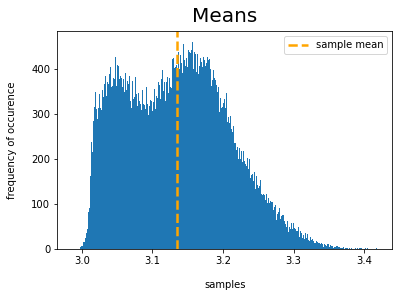

In [16]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

# result_list.sort()

# plt.axvline(x=result_list[int(len(result_list)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
# plt.axvline(x=result_list[int(len(result_list)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [17]:
#Generate 10000 testing data on GeneratorNet

In [18]:
def appen_test_G(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data_G.append(temp_list)
    testing_label_G.append(S)
# fake painting from G (random ideas)

def read_testing_data_G():
    for i in range(100000):
        #appen_test_G(sorted(np.random.rand(Agent_number_n), reverse=True));
        G_ideas = torch.randn(N_IDEAS).to(dev)  # random ideas\n
        G_values = GeneratorNet(G_ideas)
        G_values , indices = torch.sort(G_values, descending=True)
        appen_test_G(G_values.detach().cpu().numpy()) 
        
testing_data_G = []
testing_label_G = []
read_testing_data_G()
testing_data_G=np.array(testing_data_G)
testing_label_G=np.array(testing_label_G)
print(testing_data_G)
print(testing_label_G)

[[[0.00222633 0.00189164 0.00182766]
  [0.00565906 0.00189164 0.00182766]
  [0.00565906 0.00222633 0.00182766]
  [0.00565906 0.00222633 0.00189164]]

 [[0.16026327 0.05997305 0.03041615]
  [0.48554423 0.05997305 0.03041615]
  [0.48554423 0.16026327 0.03041615]
  [0.48554423 0.16026327 0.05997305]]

 [[0.778237   0.03074712 0.0023134 ]
  [0.99919873 0.03074712 0.0023134 ]
  [0.99919873 0.778237   0.0023134 ]
  [0.99919873 0.778237   0.03074712]]

 ...

 [[0.01230624 0.00656839 0.00139603]
  [0.1036894  0.00656839 0.00139603]
  [0.1036894  0.01230624 0.00139603]
  [0.1036894  0.01230624 0.00656839]]

 [[0.06358941 0.06319433 0.01893264]
  [0.2823352  0.06319433 0.01893264]
  [0.2823352  0.06358941 0.01893264]
  [0.2823352  0.06358941 0.06319433]]

 [[0.39251965 0.2806983  0.18340792]
  [0.68507785 0.2806983  0.18340792]
  [0.68507785 0.39251965 0.18340792]
  [0.68507785 0.39251965 0.2806983 ]]]
[1.         1.         1.81049624 ... 1.         1.         1.54170372]


In [19]:
result_list_G = []
for index in range(len(testing_data_G)):
    h_list = []
    for i in range(Agent_number_n):
        h = DiscriminatorNet.calculate(torch.tensor(testing_data_G[index][i]).to(dev).type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list_G.append(sum(h_list)/testing_label_G[index])
    

print(max(result_list_G),min(result_list_G),max(result_list_G)-min(result_list_G))
print(sum(result_list_G)/len(result_list_G))

3.4201659285509214 2.9972416162490845 0.4229243123018369
3.1549317651176207


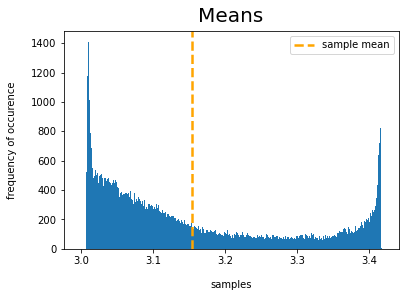

In [20]:
plt.hist(result_list_G,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list_G)/len(result_list_G), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

# result_list_G.sort()

# plt.axvline(x=result_list[int(len(result_list_G)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
# plt.axvline(x=result_list[int(len(result_list_G)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

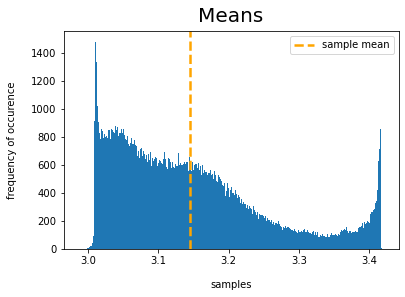

3.4201659285509214 2.9868289828300476 0.4333369457208738
3.1448972488151847


In [21]:
final_list = result_list + result_list_G


plt.hist(final_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(final_list)/len(final_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();


plt.show()


print(max(final_list),min(final_list),max(final_list)-min(final_list))
print(sum(final_list)/len(final_list))

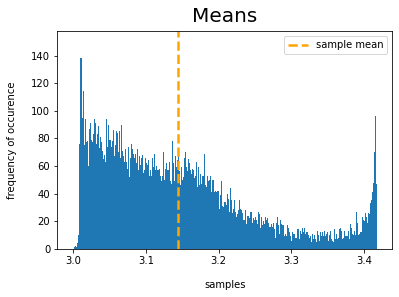

3.417697846889496 2.99926098695048 0.4184368599390158
3.1443654939941825


In [22]:
final_list = result_list[:10000] + result_list_G[:10000]


plt.hist(final_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(final_list)/len(final_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();


plt.show()


print(max(final_list),min(final_list),max(final_list)-min(final_list))
print(sum(final_list)/len(final_list))

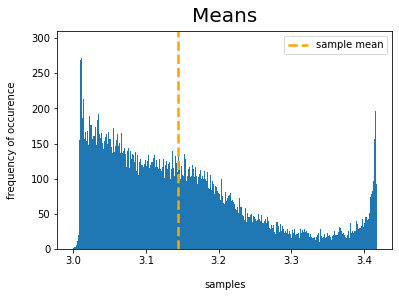

3.417697846889496 2.99926098695048 0.4184368599390158
3.1444362810098028


In [23]:
final_list = result_list[:20000] + result_list_G[:20000]


plt.hist(final_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(final_list)/len(final_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();


plt.show()


print(max(final_list),min(final_list),max(final_list)-min(final_list))
print(sum(final_list)/len(final_list))

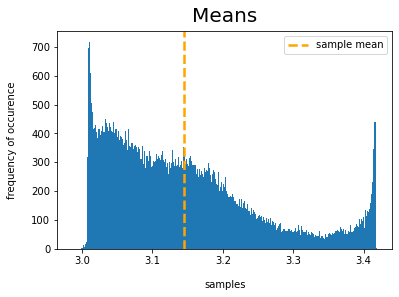

3.418692469596863 2.9868289828300476 0.4318634867668152
3.144958671660811


In [24]:
final_list = result_list[:50000] + result_list_G[:50000]


plt.hist(final_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(final_list)/len(final_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();


plt.show()


print(max(final_list),min(final_list),max(final_list)-min(final_list))
print(sum(final_list)/len(final_list))